In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

- The primal objective of SVM can be initially stated as the task of finding a hyperplane that separates the data points of different classes with the maximum margin. This hyperplane is defined by the weight vector $\mathbf{w}$ and bias $b$. The primal optimization problem can be expressed as:

    1. **Objective:** Minimize $\frac{1}{2}||\mathbf{w}||^2$. This corresponds to maximizing the margin between the two classes, as the margin is inversely proportional to $||\mathbf{w}||$.

    2. **Constraint:** For each data point $i$, ensure that it is correctly classified with a margin of at least 1. This is expressed as $y_i(\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1$, for $i = 1, \ldots, n$, where $y_i$ is the label of the $i$-th data point, and $\mathbf{x}_i$ is its feature vector.

- To allow for misclassification and points within the margin (soft margin SVM), we introduce slack variables $\xi_i \geq 0$ for each data point. The optimization problem is modified to accommodate misclassifications:

    1. **Objective:** Minimize $\frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi_i$.
   
    2. **Constraints:** The constraints are modified as $y_i(\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1 - \xi_i$, and $\xi_i \geq 0$, for all $i$.

    Here, $C$ is a regularization parameter that controls the trade-off between the slack variable penalty and the margin width.

- The term $[1 - y_i(\mathbf{w} \cdot \mathbf{x}_i + b)]_+$ represents the hinge loss, which is equivalent to $\max(0, 1 - y_i(\mathbf{w} \cdot \mathbf{x}_i + b))$. The hinge loss is 0 for points correctly classified outside the margin, and increases linearly for points misclassified or within the margin.

    The optimization problem can then be rewritten by substituting the slack variable expression with the hinge loss expression:

    $$ \text{argmin}_{\mathbf{w}, b} \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [1 - y_i(\mathbf{w} \cdot \mathbf{x}_i + b)]_+ \right) $$

- In scenarios where the data is not linearly separable in its original space, SVM can be extended to use a feature mapping $\Phi$, which maps the input vectors into a higher-dimensional space where the data may become linearly separable:

    $$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, b \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + b )]_+ \right) $$

    Here, $\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle$ denotes the dot product in the feature space, and $\mathcal{H}$ represents the Hilbert space into which the input data is mapped.

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div>

### Hinge Loss vs. Loss in Binary Classification

1. **Hinge Loss:** In the context of SVM, the hinge loss serves as a proxy for the classification error, providing a smooth, convex approximation to the non-differentiable 0-1 loss. It does not directly measure the classification error (i.e., the fraction of misclassified points) but imposes a continuous penalty for predictions that are incorrect or too close to the decision boundary. This allows the optimization to focus on the most challenging examples — those near the decision boundary.

2. **0-1 Loss in Binary Classification:** The 0-1 loss function directly measures the classification error by assigning a loss of 1 to any misclassified example and 0 to correctly classified examples. This loss function is intuitively appealing because it directly corresponds to the classification error rate. However, it is non-convex and non-differentiable, posing significant challenges for optimization.

There are three principal reasons for use Hinge loss instead of the loss binary classification:

1. **Classification Error:** the error can be directly quantified by counting the number of misclassified examples. However, this direct measure of classification error is not differentiable and hence not suitable for optimization algorithms that require gradient computations.

2. **Convex Upper Bound:** The hinge loss function provides a differentiable and convex upper bound to the 0-1 loss function, which directly quantifies classification error (0 for correct classification, 1 for misclassification). Being convex, the hinge loss ensures that the optimization problem has a global minimum, making it easier to solve using gradient-based methods.

3. **Penalization:** The hinge loss increases linearly for predictions that are on the wrong side of the margin boundary (i.e., it penalizes both misclassifications and correct classifications that are too close to the decision boundary). 

## Example of using the SVC class from scikit-learn

In [25]:
#  Data Generation
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 1.0
Testing score : 0.9


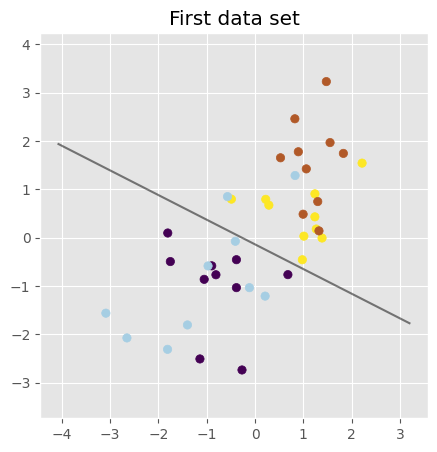

In [26]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

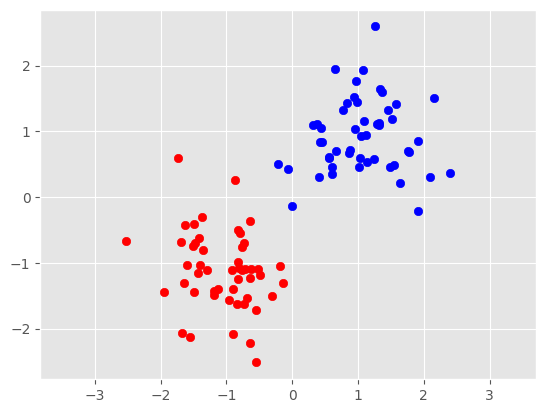

In [27]:
# Create two centers for the two distributions
centers = [[1, 1], [-1, -1]]
stds = [0.5, 0.5]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=stds)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [28]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
from scipy.stats import multivariate_normal

# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk

n_mc = X.shape[0] # Repeat this n_mc times - enough to approximate 
expectation = 0

for i in range(n_mc):
    
    # Random binary choice: will the point be generated from the first or second gaussian ? 
    # R/ Choose randomly between 0 and 1
    rand = np.random.choice(y) 
    
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean=centers[0], cov=[(1,1),(1,1)]  )
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean=centers[1], cov=[(1,1),(1,1)] )

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !  
          
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=1)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=1)

    # Compute the risk from these and add it to the total
    expectation += min( p1 / (p1+p2), p2 / (p1+p2))

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.106
Estimated Bayes accuracy: 0.894


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 1.0/0.96


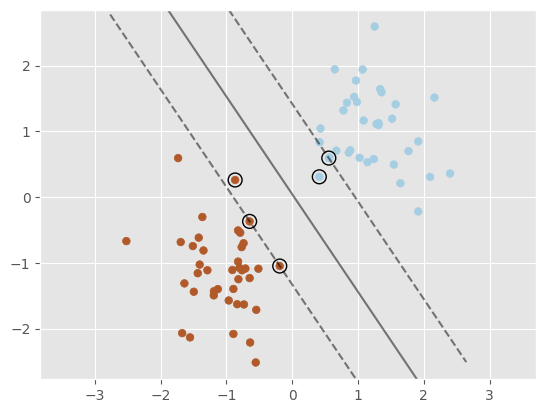

In [30]:
# Create a linear SVM and train it on the training data
penalty = 0.5

clf = SVC(kernel='linear', C=penalty)
clf.fit(X_train, y_train)

print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# Plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plot the support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

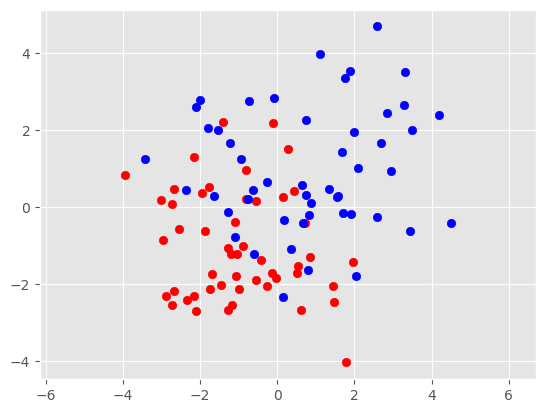

In [31]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5

# Implementing the two blobs
# Setting the centers and standard deviations
centers = [[1, 1], [-1, -1]]
stds = [1.5, 1.5]

# Generate the data
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=stds)

# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

Best C: 0.03162277660168379


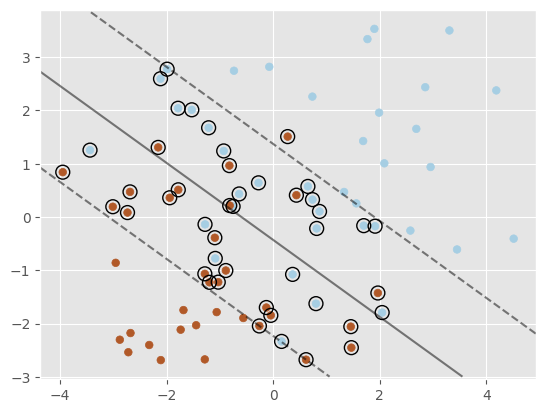

In [32]:
# Finding the best working C with a 5-fold cross-validation
# Looking into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}

# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

# Create a SVM model
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# Get the best C parameter
GridSearchCV(estimator=SVC(), param_grid=parameters)
bestC = clf.best_params_['C']

print(f'Best C: {bestC}')

clf = svm.SVC(kernel="linear", C=bestC)
clf.fit(X_train,y_train)

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# Plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plot the support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

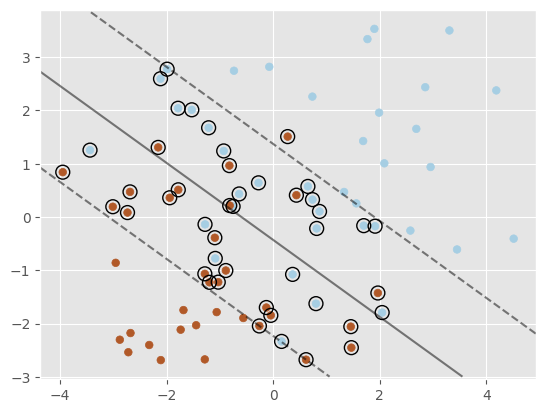

In [33]:
# Implementing the SVM with the best C
clf = svm.SVC(kernel="linear", C=bestC)
clf.fit(X_train, y_train)

# Plotting the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# Plotting the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Creating grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plotting teh decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plotting the support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

C = 0.0, Gamma = 0.1, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 1.0, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 10.0, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 100.0, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 0.1, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 1.0, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 10.0, Train score = 0.533, Test score = 0.400
C = 0.0, Gamma = 100.0, Train score = 0.533, Test score = 0.400
C = 1.0, Gamma = 0.1, Train score = 0.827, Test score = 0.680
C = 1.0, Gamma = 1.0, Train score = 0.893, Test score = 0.520
C = 1.0, Gamma = 10.0, Train score = 0.987, Test score = 0.440
C = 1.0, Gamma = 100.0, Train score = 1.000, Test score = 0.400
C = 31.6, Gamma = 0.1, Train score = 0.853, Test score = 0.640
C = 31.6, Gamma = 1.0, Train score = 0.960, Test score = 0.480
C = 31.6, Gamma = 10.0, Train score = 1.000, Test score = 0.480
C = 31.6, Gamma = 100.0, Train score = 1.000, Test score 

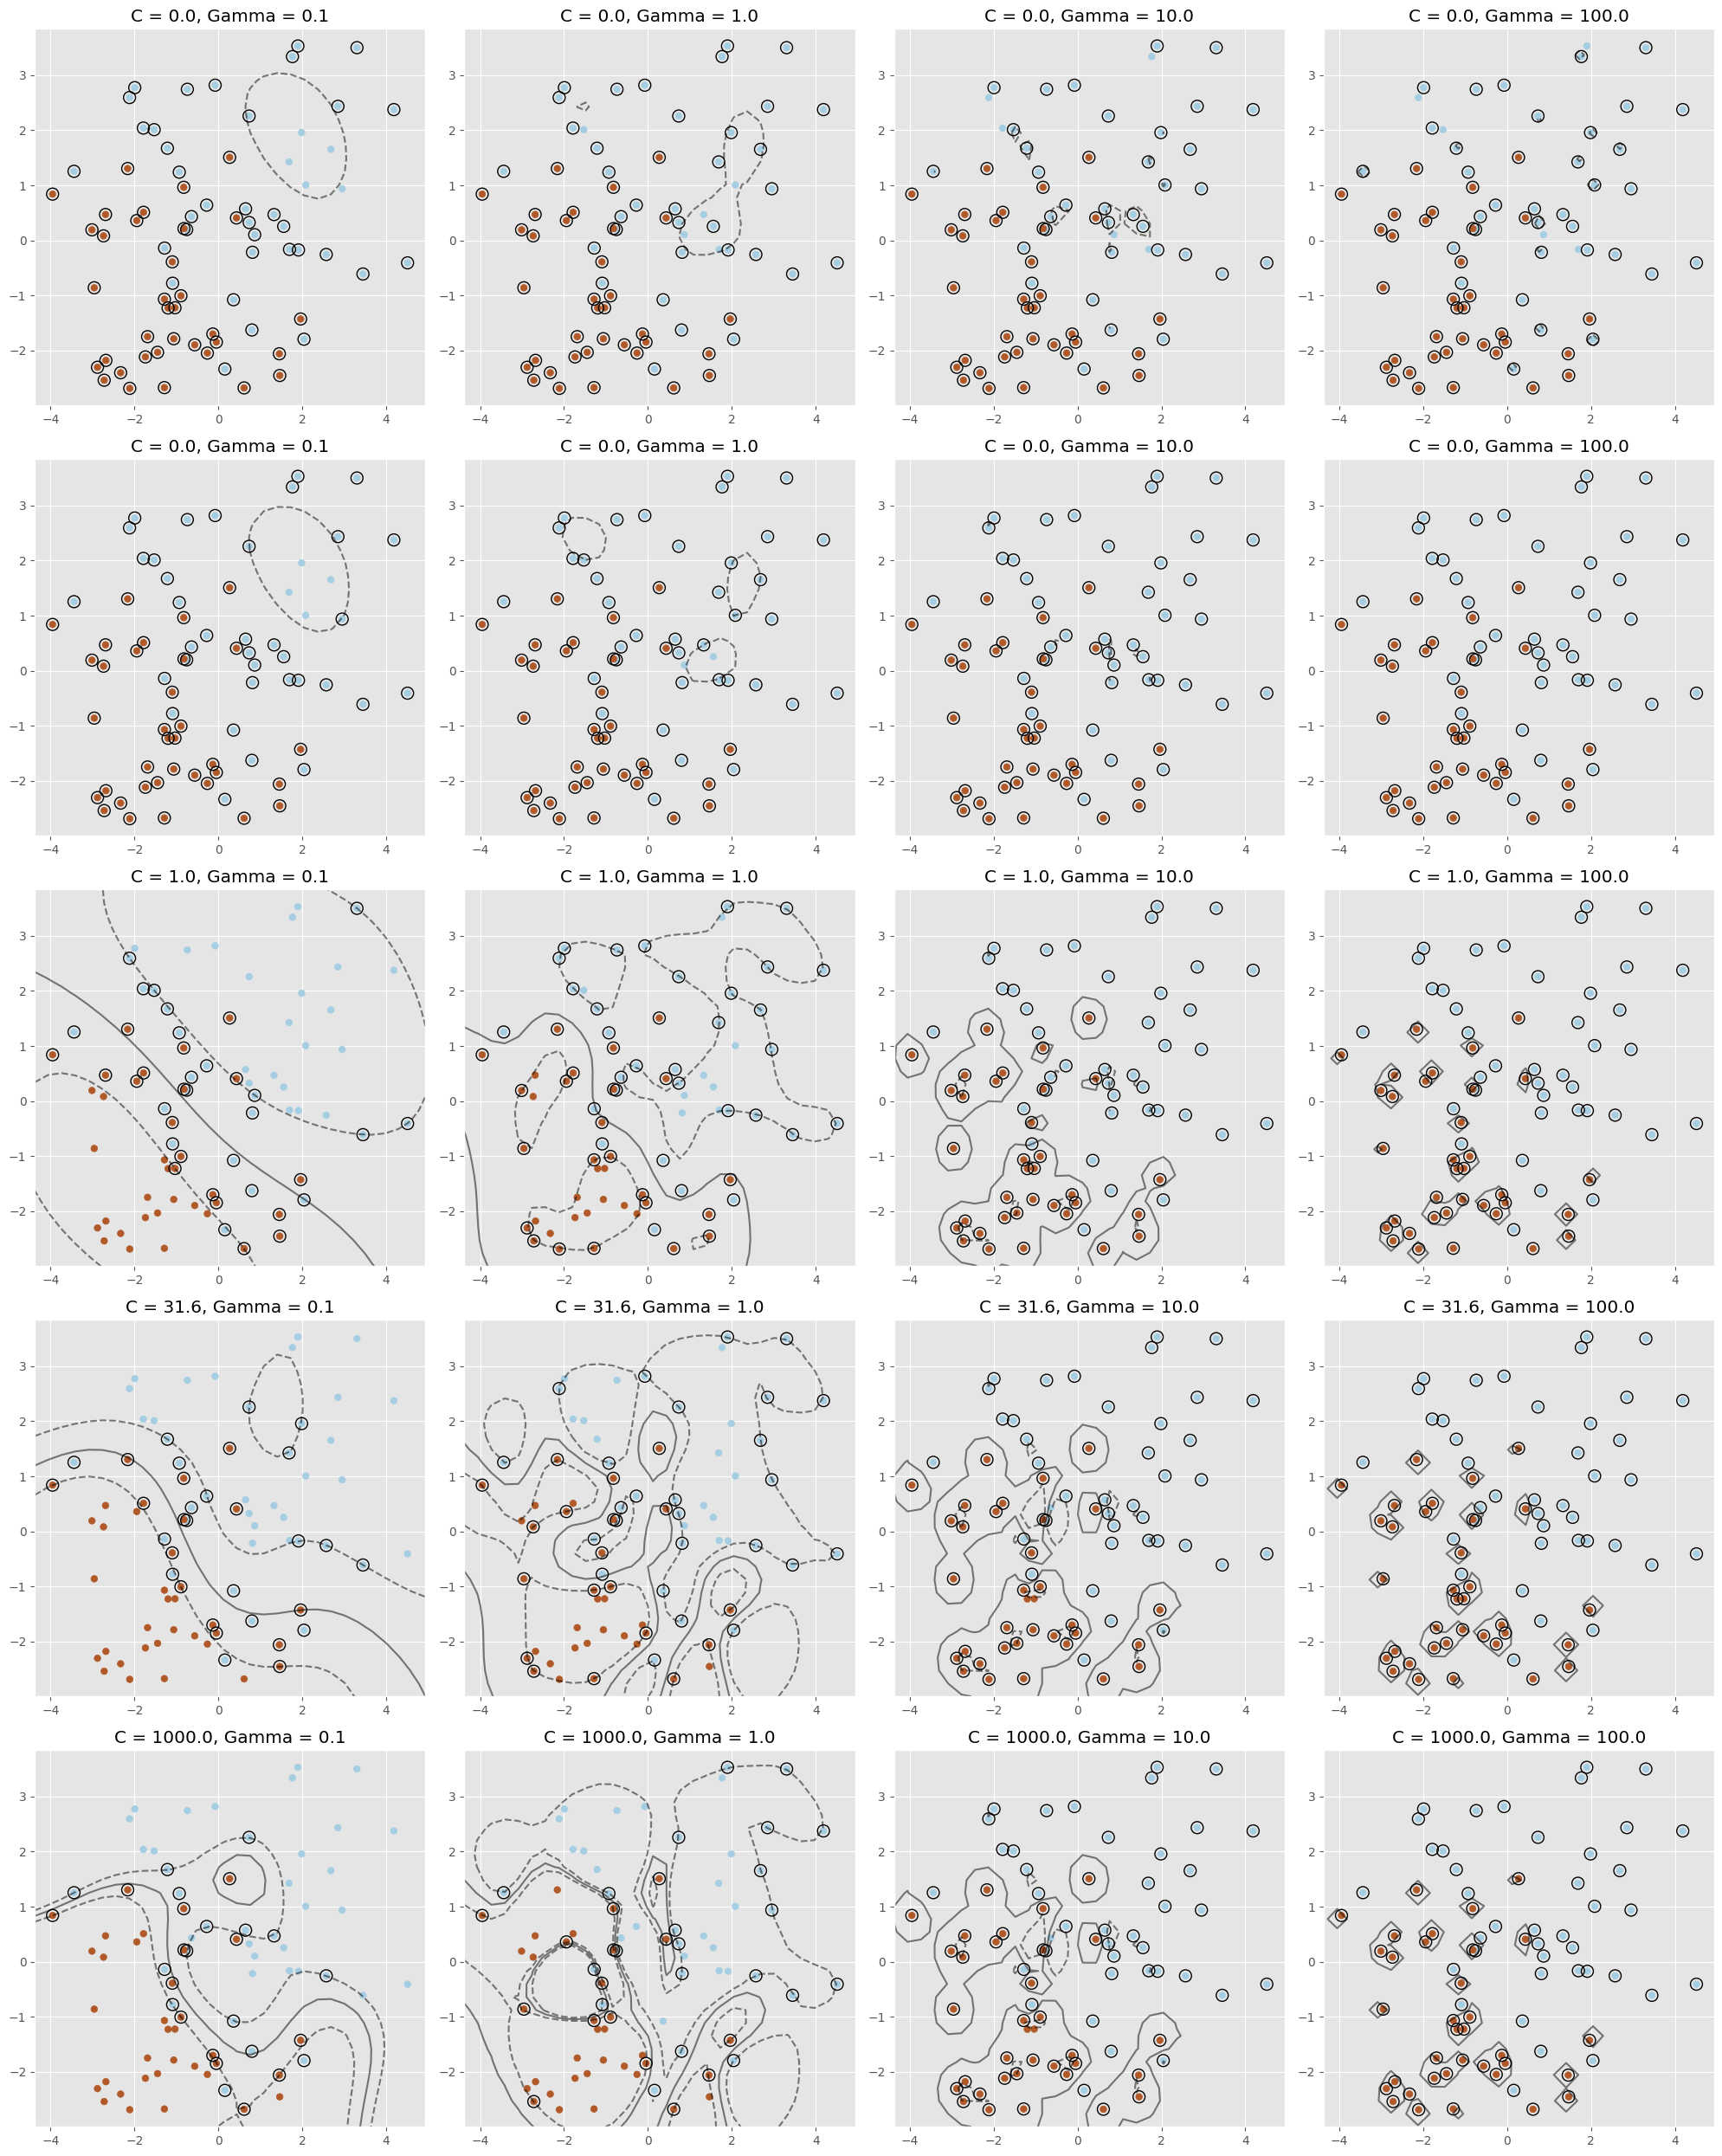

In [34]:
gammas = [0.1, 1, 10, 100]
penalty = np.logspace(-3, 3, 5)
# Create a gaussian svm and vary the parameter of the kernel,
# check the difference between training and testing scores

# Create a grid of subplots
fig, axes = plt.subplots(len(penalty), len(gammas), figsize=(20, 25))

# Iterate over penalty values
for i, p in enumerate(penalty):
    # Iterate over gamma values
    for j, g in enumerate(gammas):
        # Create and fit the SVM model
        clf = svm.SVC(kernel="rbf", C=p, gamma=g)
        clf.fit(X_train, y_train)

        # Print penalty, gamma values and train/test scores 
        print(f"C = {p:.1f}, Gamma = {g:.1f}, Train score = {clf.score(X_train, y_train):.3f}, Test score = {clf.score(X_test, y_test):.3f}")

        # Plotting the data
        axes[i, j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

        # Plotting the decision function
        xlim = axes[i, j].get_xlim()
        ylim = axes[i, j].get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)
        axes[i, j].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

        # Plotting support vectors
        axes[i, j].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

        # Set plot title using just one decimal for the penalty and gamma values
        axes[i, j].set_title(f"C = {p:.1f}, Gamma = {g:.1f}")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

The $ C $ parameter regulates the trade-off between achieving a low training error and maintaining a small margin. A high $ C $ value leads to a smaller margin, fitting the training data closely, which could lead to overfitting; the model may capture noise and outliers, potentially reducing its ability to generalize to new, unseen data. On the other hand, a low $ C $ value allows for a larger margin, possibly at the expense of increased training errors, but often results in better generalization.

The $ \gamma $ parameter controls the extent of the influence of a single training example. High $ \gamma $ values cause the decision boundary to bend around individual data points, creating a highly complex and tightly tailored fit that can capture noise, leading to overfitting. Conversely, low $ \gamma $ values yield a smoother decision boundary that generalizes better to new data. Inappropriate tuning of $ \gamma $ can cause the model to lose its capacity to capture the intricacies of the data if too low, or to capture too much noise if too high.

Overfitting manifests as an SVM model that performs exceedingly well on training data but poorly on unseen test data. This situation is observed when the decision boundary is excessively non-linear and wraps closely around training points, as opposed to forming a more generalized and smooth boundary. By tuning $ C $ and $ \gamma $, one aims to find a balance where the model fits the training data well but also retains the flexibility to apply this fit to new data, thus performing well on both the training set and unseen data.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

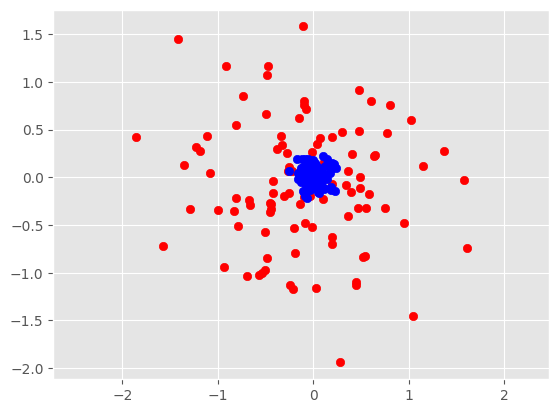

In [36]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

centers = [(0,0), (0, 0)]
std_dev = np.array([[0.1, 0.1], [0.7, 0.7]])
X, y = make_blobs(n_samples=200, centers=centers, n_features=2, cluster_std=std_dev, random_state=0)

# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos, 0], X[pos, 1], c='r')
plt.scatter(X[neg, 0], X[neg, 1], c='b')
plt.axis('equal')
plt.show()

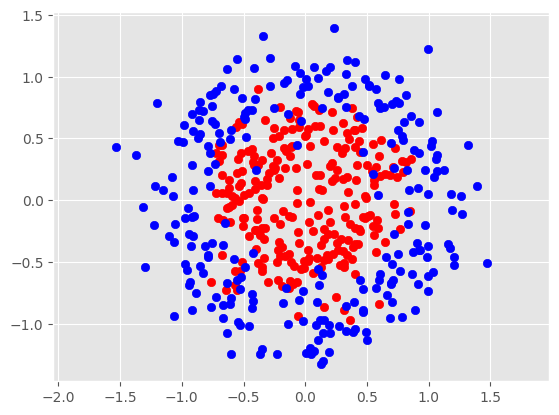

In [52]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

centers = [(0,0) , (0,0)]
X, y = make_circles(n_samples=500, factor=0.5, noise=0.2 , random_state=0)
 
# Using sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Plotting the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

Best C: 0.001


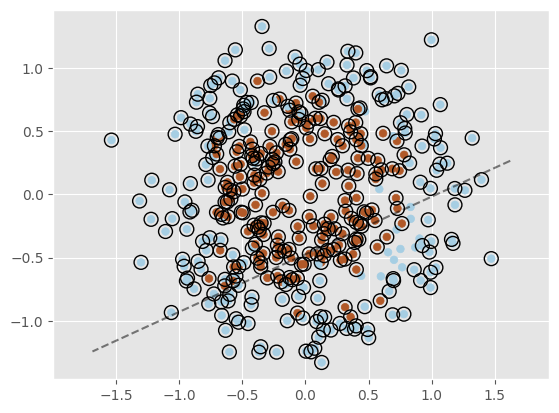

In [57]:
# Finding the best working C with a 5-fold cross-validation
# Looking into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}

# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

# Create a SVM model
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# Get the best C parameter
GridSearchCV(estimator=SVC(), param_grid=parameters)
bestC = clf.best_params_['C']

print(f'Best C: {bestC}')

clf = svm.SVC(kernel="linear", C=bestC)
clf.fit(X_train,y_train)

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# Plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plot the support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

The best C parameter is: 1.000000


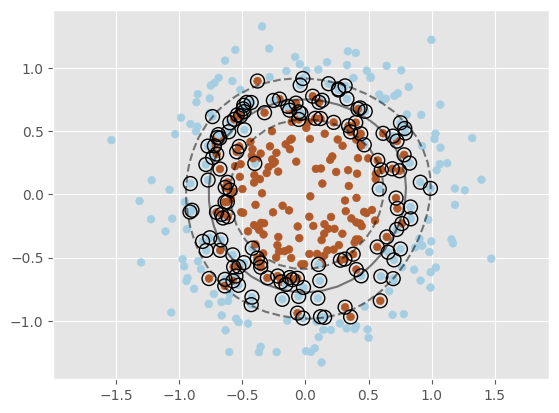

In [58]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C and gamma
parameters = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5)), 'gamma': list([0.1, 1, 10, 100])}

# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
GridSearchCV(estimator=SVC(), param_grid=parameters)
bestC = clf.best_params_['C']

print("The best C parameter is: %f" %bestC)

bestgamma = clf.best_params_['gamma']

clf = svm.SVC(kernel="rbf", C=bestC , gamma=bestgamma)
clf.fit(X_train,y_train)

# Plotting the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# Plotting the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Creating grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plotting decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# Plotting support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

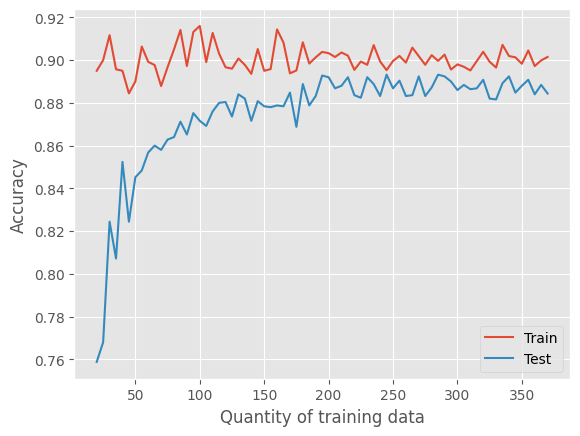

In [59]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        svc = svm.SVC(kernel="rbf", C=bestC , gamma=bestgamma)
        
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
        
    # Add the average of the scores to the lists
    scores_train.append(score_train/n_m)
    scores_test.append(score_test/n_m)

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [60]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 

def bayes_risk(X,y):

    n_mc = X.shape[0] # Repeat this n_mc times - enough to approximate 
    expectation = 0
    
    for i in range(n_mc):
        
        # Random binary choice: will the point be generated from the first or second gaussian ? 
        rand = np.random.choice(y) 
        
        if rand==0:
            # First case: y = 0
            x = np.random.multivariate_normal(mean=centers[0], cov=[(1,1),(1,1)]  )
        else:
            # Second case: y = 1
            x = np.random.multivariate_normal(mean=centers[1], cov=[(0.3,0.3),(0.3,0.3)] )

        # You have to compute the conditional posterior probability of x given the 2 gaussians 
        # Use the multivariate_normal.pdf() method !    
        p1 = multivariate_normal.pdf(x, mean=centers[0], cov=1)
        p2 = multivariate_normal.pdf(x, mean=centers[1], cov=0.3)

        # Compute the risk from these and add it to the total
        #expectation += min(p1, p2)
        expectation += min( p1 / (p1+p2), p2 / (p1+p2)) 
        expectation /= n_mc

    return expectation

expectation = bayes_risk(X,y)

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')


Estimated Bayes risk: 0.001
Estimated Bayes accuracy: 0.999


In [61]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []
bayes_risks = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    bayes_r = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        svc = svm.SVC(kernel="rbf", C=bestC , gamma=bestgamma)
        
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Calculate bayes risk
        bayes_r += bayes_risk(X_train_reduced,y_train_reduced)
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
        
    # Add the average of the scores to the lists
    scores_train.append(score_train/n_m)
    scores_test.append(score_test/n_m)
    bayes_risks.append(bayes_r/n_m)


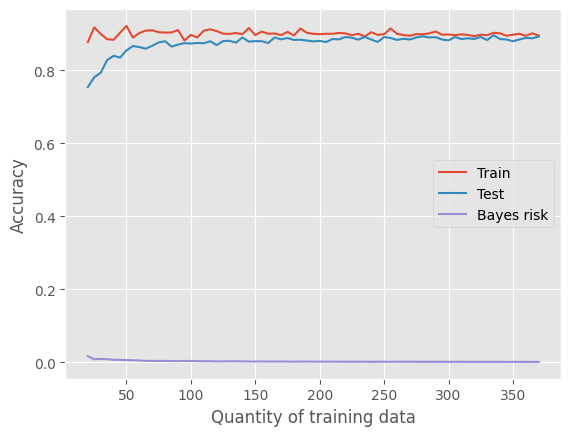

In [62]:
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.plot(sizes, bayes_risks, label='Bayes risk')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>

ANALYSIIIIISSS

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

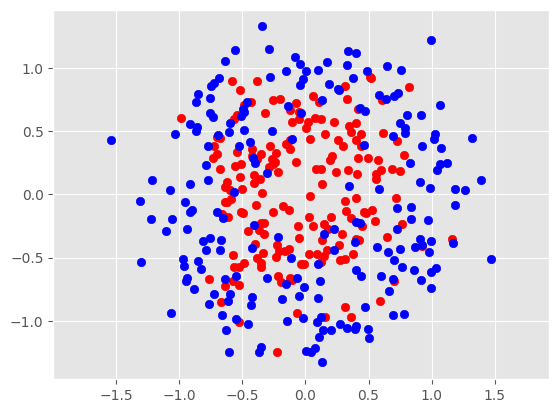

In [63]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

C = 0.1, Train score = 0.789, Test score = 0.896
C = 10.0, Train score = 0.800, Test score = 0.896


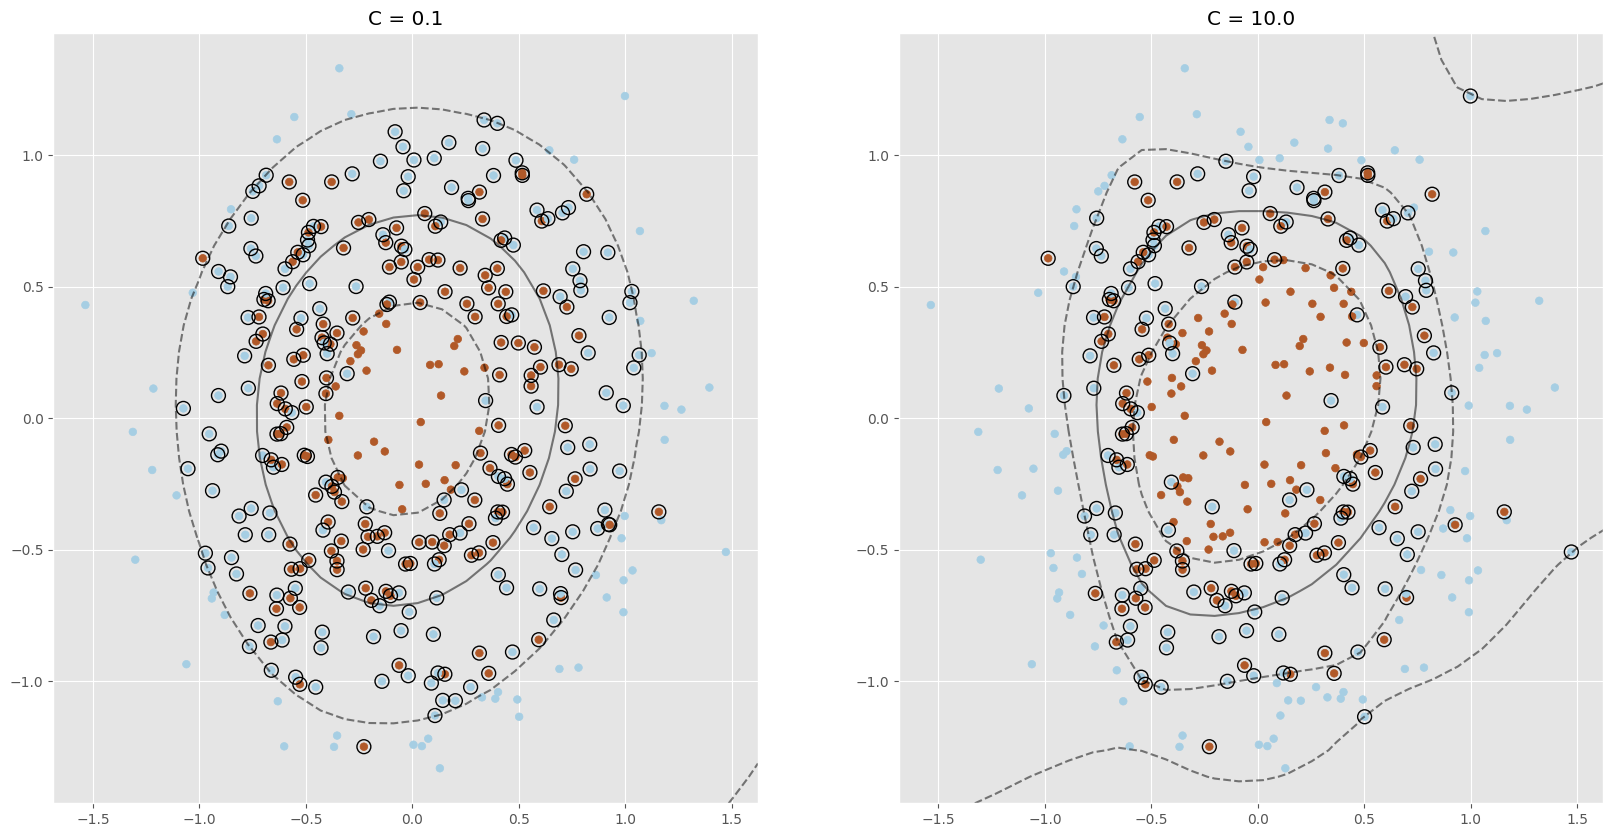

In [64]:
# Vary the appropriate parameter and plot the training/testing results

# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Iterate over penalty values
for i, p in enumerate([0.1, 10]):
    # Create and fit the SVM model
    clf = svm.SVC(kernel="rbf", C=p)
    clf.fit(X_train, y_train)

    # Print penalty, gamma values and train/test scores 
    print(f"C = {p:.1f}, Train score = {clf.score(X_train, y_train):.3f}, Test score = {clf.score(X_test, y_test):.3f}")

    # Plotting the data
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

    # Plotting the decision function
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    axes[i].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Plotting support vectors
    axes[i].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

    # Set plot title using just one decimal for the penalty and gamma values
    axes[i].set_title(f"C = {p:.1f}")


<div class='alert alert-block alert-warning'>
            Answer:</div>

ANALIIISIIIISSS

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [65]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [66]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

Fitting the classifier to the training set


In [67]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.111s
Chance level : 0.6210526315789474
Accuracy : 0.9210526315789473


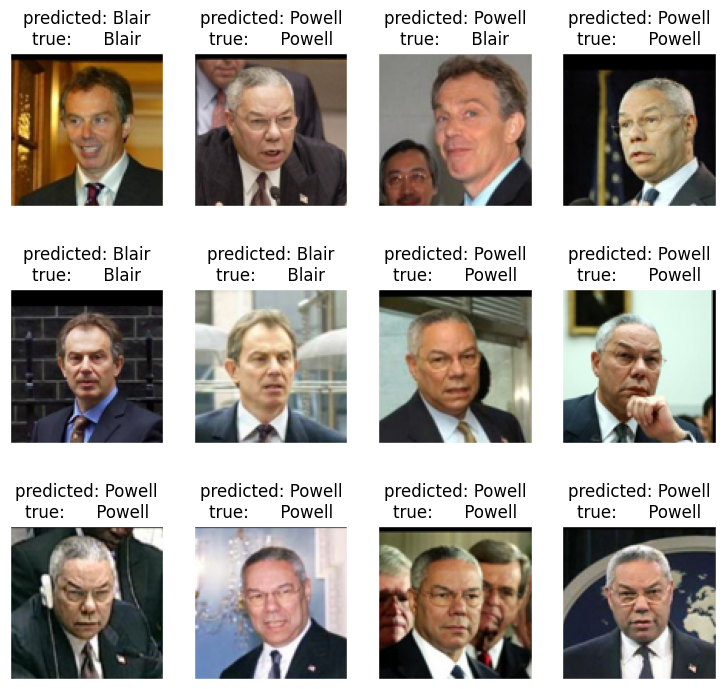

In [68]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

In [69]:
# Add a number of nuisance variable to the existing data points, 
# by generating randomly their values

# Generate the nuisance variables
n_nuisance = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_nuisance)
X_train[idx, :] = np.random.randn(n_nuisance, X_train.shape[1])

# Fit the classifier and compute the scores on training and test data
clf.fit(X_train, y_train)
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f'Train score: {score_train:.3f}, Test score: {score_test:.3f}')



Train score: 1.000, Test score: 0.868


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

Train score: 1.000, Test score: 0.863


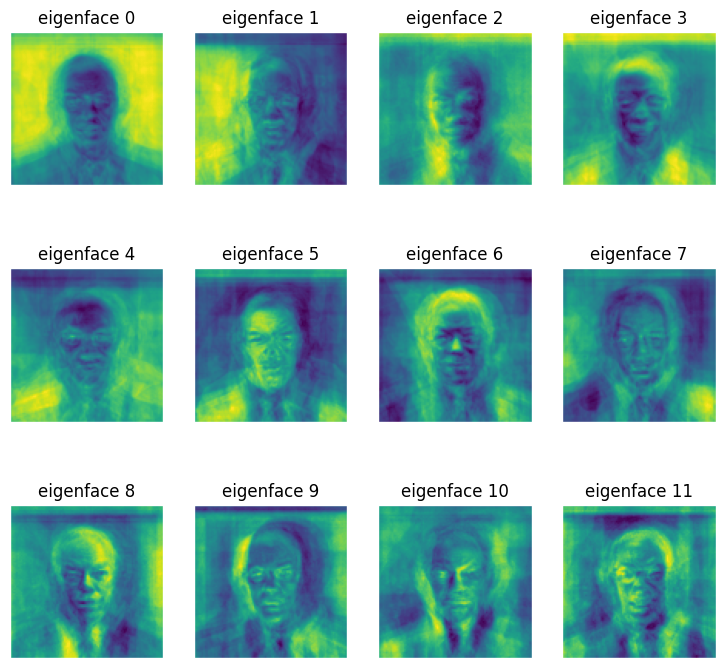

In [70]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA

from sklearn.decomposition import PCA

# Create a PCA model
n_components = 150
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# Apply the PCA model to the training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit the classifier and compute the scores on training and test data
clf.fit(X_train_pca, y_train)
score_train = clf.score(X_train_pca, y_train)
score_test = clf.score(X_test_pca, y_test)

print(f'Train score: {score_train:.3f}, Test score: {score_test:.3f}')

# Plot the eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# Plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles)
pl.show()
